In [1]:
import numpy as np
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Hyperparameters & Configuration 
CONFIG = {
    'seed': 42,
    'learning_rate': 0.01,
    'epochs': 1000,
    'batch_size': 32,
    'l2_lambda': 0.001,       # Regularization strength
    'lr_decay': 0.95,         # Learning rate decay factor
    'lr_decay_step': 50,      # Decay every N epochs
    'bottleneck_dim': 2       # Dimension of the latent space
}

# Set global seed
np.random.seed(CONFIG['seed'])
print("Configuration loaded.")

Configuration loaded.


In [2]:
df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                            "uciml/breast-cancer-wisconsin-data",
                            "data.csv" )

print(df.shape)

(569, 33)


In [4]:
y = df["diagnosis"].map({"M": 1, "B": 0}).values

# drop non-feature columns
X_raw = df.drop(columns=["id", "diagnosis", "Unnamed: 32"], errors="ignore").values

if np.isnan(X_raw).any():
    print("Missing values detected. Imputing with column means...")
    # Calculate mean of each column ignoring NaNs
    col_mean = np.nanmean(X_raw, axis=0)
    
    # Find indices where values are NaN
    inds = np.where(np.isnan(X_raw))
    
    # Replace NaNs with the corresponding column mean
    X_raw[inds] = np.take(col_mean, inds[1])
else:
    print("No missing values found.")
# standardize features
scaler = StandardScaler()
x = scaler.fit_transform(X_raw)

print(x.shape)  

No missing values found.
(569, 30)


In [5]:
class K_means:
    def __init__(self, k, init, max_itrns=100, tolerance=1e-4, random_state=None):
        self.k = k
        self.init = init
        self.max_itrns = max_itrns
        self.tolerance = tolerance
        self.random_state = random_state
        self.centroids = None
        self.labels = None
        self.inertia_history = []
    
    def _init_random(self, x):
        num_of_samples = x.shape[0] # rows
        indices = np.random.choice(num_of_samples, size=self.k, replace=False)
        return  x[indices]
    
    def _init_Kpp(self, x):
        num_of_samples = x.shape[0] # rows
        index = np.random.randint(num_of_samples) # only one sample
        centroids = []
        centroids.append(x[index])

        for _ in range(1, self.k):
            dists_sq = np.min(
                    [np.sum((x - c) ** 2, axis=1) for c in centroids],
                    axis=0
                ) # for each point in x:
                # compute distance to every centroid
                # keep the smallest one
            probs = dists_sq / np.sum(dists_sq)
            index = np.random.choice(num_of_samples, p=probs) 
            centroids.append(x[index])

        return np.array(centroids)

    def assign_clusters(self, x):
        distances = np.linalg.norm(x[:, None] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def compute_centroids(self, x):
        new_centroids = np.array([
            x[self.labels == i].mean(axis=0)
            if i in self.labels
            else self.centroids[i]  # handle empty cluster
            for i in range(self.k)
        ])
        return new_centroids

    def compute_inertia(self, x):
        return np.sum((x - self.centroids[self.labels]) ** 2)
    
    def fit(self, x):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        if self.init == "random":
            self.centroids = self._init_random(x)
        elif self.init == "kmeans++":
            self.centroids = self._init_Kpp(x)
        else:
            raise ValueError("init must be 'random' or 'kmeans++'")

        for _ in range(self.max_itrns):
            self.labels = self.assign_clusters(x)
            inertia = self.compute_inertia(x)
            self.inertia_history.append(inertia)

            new_centroids = self.compute_centroids(x)

            # tolerance-based convergence
            shift = np.linalg.norm(self.centroids - new_centroids)
            if shift < self.tolerance:
                break

            self.centroids = new_centroids
        return self

    def predict(self, x):
        return self.assign_clusters(x)

In [6]:
class Activation:
    @staticmethod
    def forward(z, name):
        if name == 'relu': return np.maximum(0, z)
        if name == 'sigmoid': return 1 / (1 + np.exp(-z))
        if name == 'tanh': return np.tanh(z)
        if name == 'linear': return z
        return z

    @staticmethod
    def derivative(z, name):
        if name == 'relu': return (z > 0).astype(float)
        if name == 'sigmoid': 
            s = 1 / (1 + np.exp(-z))
            return s * (1 - s)
        if name == 'tanh': return 1 - np.tanh(z)**2
        if name == 'linear': return np.ones_like(z)
        return np.ones_like(z)

class DenseLayer:
    def __init__(self, n_in, n_out, activation):
        # He initialization for stability
        self.weights = np.random.randn(n_in, n_out) * np.sqrt(2.0 / n_in)
        self.bias = np.zeros((1, n_out))
        self.activation_name = activation
        
        # Cache for backprop
        self.input_data = None
        self.z = None
        
        # Gradients
        self.dW = None
        self.db = None

    def forward(self, x):
        self.input_data = x
        self.z = np.dot(x, self.weights) + self.bias
        return Activation.forward(self.z, self.activation_name)

    def backward(self, d_out, learning_rate, l2_lambda):
        # 1. Gradient through activation
        d_z = d_out * Activation.derivative(self.z, self.activation_name)
        
        # 2. Gradients for weights and bias
        # Include L2 Regularization derivative: d/dw(0.5 * lambda * w^2) = lambda * w
        self.dW = np.dot(self.input_data.T, d_z) + (l2_lambda * self.weights)
        self.db = np.sum(d_z, axis=0, keepdims=True)
        
        # 3. Gradient to pass to previous layer
        d_input = np.dot(d_z, self.weights.T)
        
        # 4. Update parameters (Gradient Descent)
        self.weights -= learning_rate * self.dW
        self.bias -= learning_rate * self.db
        
        return d_input

In [7]:
class Autoencoder:
    def __init__(self, structure, activations, l2_lambda):
        self.layers = []
        self.l2_lambda = l2_lambda
        self.loss_history = []
        
        # Build the network based on the list of layer sizes
        for i in range(len(structure) - 1):
            self.layers.append(DenseLayer(
                structure[i], 
                structure[i+1], 
                activations[i]
            ))
            
    def forward(self, X):
        out = X
        for layer in self.layers:
            out = layer.forward(out)
        return out
    
    def compute_loss(self, y_true, y_pred):
        # MSE Loss
        mse = np.mean((y_true - y_pred) ** 2)
        
        # L2 Regularization Loss
        l2_loss = 0
        for layer in self.layers:
            l2_loss += np.sum(layer.weights ** 2)
            
        return mse + (0.5 * self.l2_lambda * l2_loss)

    def train(self, X, epochs, batch_size, lr, decay_rate, decay_step):
        n_samples = X.shape[0]
        
        for epoch in range(epochs):
            # Shuffle data
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            
            # LR Schedule
            if epoch > 0 and epoch % decay_step == 0:
                lr *= decay_rate
            
            epoch_loss = 0
            num_batches = 0
            
            # Mini-batch loop
            for start in range(0, n_samples, batch_size):
                end = min(start + batch_size, n_samples)
                batch_X = X_shuffled[start:end]
                
                # 1. Forward
                output = self.forward(batch_X)
                
                # 2. Loss calculation
                loss = self.compute_loss(batch_X, output)
                epoch_loss += loss
                num_batches += 1
                
                # 3. Backward
                # Derivative of MSE w.r.t output: 2/N * (pred - true)
                # We often drop the 2 depending on the loss definition (0.5*MSE)
                # Here we use simply: (Output - Input) / Batch_Size
                d_out = (output - batch_X) / batch_X.shape[0]
                
                for layer in reversed(self.layers):
                    d_out = layer.backward(d_out, lr, self.l2_lambda)
            
            # Store average loss
            self.loss_history.append(epoch_loss / num_batches)
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch} | Loss: {self.loss_history[-1]:.6f} | LR: {lr:.5f}")

    def get_latent(self, X):
        # Pass through the encoder part (first half of layers)
        out = X
        # Encoder is half the total layers (assuming symmetric structure)
        encoder_len = len(self.layers) // 2
        for i in range(encoder_len):
            out = self.layers[i].forward(out)
        return out

In [15]:
%run ./Metrics.ipynb

In [20]:
# Configuration 
bottleneck_sizes = [2, 5, 10, 15, 20]
input_dim = x.shape[1]

# Results Storage
results_ae = {
    'bottleneck': [],
    'recon_loss': [],
    'ari': [],
    'nmi': [],
    'silhouette': []
}

print(f"{'Bottleneck':<10} | {'Final Loss':<10} | {'ARI Score':<10}")
print("-" * 40)

for bn in bottleneck_sizes:
    # 1. Define Architecture (Symmetric)
    # 30 -> 24 -> 16 -> 8 -> [BN] -> 8 -> 16 -> 24 -> 30
    structure = [input_dim, 24, 16, 8, bn, 8, 16, 24, input_dim]
    activations = ['tanh', 'tanh', 'tanh', 'linear', 'tanh', 'tanh', 'tanh', 'linear']
    
    # 2. Train Autoencoder
    ae = Autoencoder(structure, activations, l2_lambda=0.001)
    ae.train(x, epochs=300, batch_size=32, lr=0.01, decay_rate=0.95, decay_step=50)
    
    # 3. Get Latent Representations
    X_latent = ae.get_latent(x)
    
    # 4. Get Reconstruction Loss (Final Loss from history)
    final_loss = ae.loss_history[-1]
    
    # 5. Run K-Means on Latent Data
    kmeans = K_means(k=2, init='kmeans++', max_itrns=100, random_state=42)
    kmeans.fit(X_latent)
    labels = kmeans.labels
    
    # 6. Compute Metrics
    ari = adjusted_rand_index_manual(y, labels)
    nmi = nmi_manual(y, labels)
    sil = silhouette_score_manual(X_latent, labels)
    
    # Store
    results_ae['bottleneck'].append(bn)
    results_ae['recon_loss'].append(final_loss)
    results_ae['ari'].append(ari)
    results_ae['nmi'].append(nmi)
    results_ae['silhouette'].append(sil)
    
    print(f"{bn:<10} | {final_loss:.5f}     | {ari:.4f}")

Bottleneck | Final Loss | ARI Score 
----------------------------------------
Epoch 0 | Loss: 1.065099 | LR: 0.01000
Epoch 100 | Loss: 0.477576 | LR: 0.00903
Epoch 200 | Loss: 0.443480 | LR: 0.00815
2          | 0.43061     | 0.7927
Epoch 0 | Loss: 1.145292 | LR: 0.01000
Epoch 100 | Loss: 0.338982 | LR: 0.00903
Epoch 200 | Loss: 0.293971 | LR: 0.00815
5          | 0.27808     | 0.7369
Epoch 0 | Loss: 1.206887 | LR: 0.01000
Epoch 100 | Loss: 0.307430 | LR: 0.00903
Epoch 200 | Loss: 0.262992 | LR: 0.00815
10         | 0.25386     | 0.6407
Epoch 0 | Loss: 1.180270 | LR: 0.01000
Epoch 100 | Loss: 0.315016 | LR: 0.00903
Epoch 200 | Loss: 0.272579 | LR: 0.00815
15         | 0.25289     | 0.7612
Epoch 0 | Loss: 1.077583 | LR: 0.01000
Epoch 100 | Loss: 0.299636 | LR: 0.00903
Epoch 200 | Loss: 0.266153 | LR: 0.00815
20         | 0.27776     | 0.7129


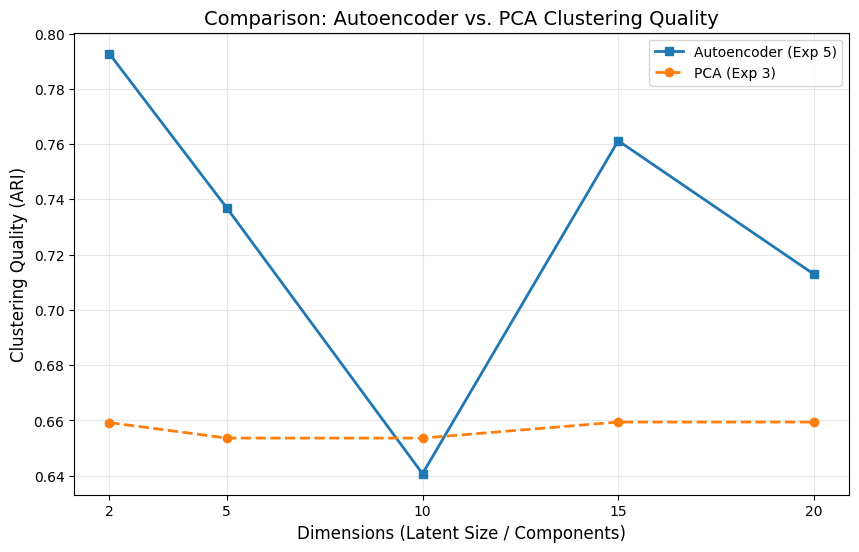

In [22]:
import matplotlib.pyplot as plt

# From CURRENT Notebook (Experiment 5 - Autoencoder)
results_ae = {'bottleneck': [2, 5, 10, 15, 20], 'ari': [0.7927, 0.7369,0.6407, 0.7612,0.7129]} 


# (Experiment 3 - PCA)
# LOOK AT YOUR OTHER NOTEBOOK AND TYPE THE ARI SCORES HERE:
pca_results_ari = [
    0.6592,  # ARI for 2 components
    0.6536,  # ARI for 5 components
    0.6536,  # ARI for 10 components
    0.6594,  # ARI for 15 components
    0.6594  # ARI for 20 components
]

#  Generate Comparison Plot 
bottleneck_sizes = [2, 5, 10, 15, 20]

plt.figure(figsize=(10, 6))

# Plot Autoencoder Line
plt.plot(results_ae['bottleneck'], results_ae['ari'], 
         marker='s', linestyle='-', color='tab:blue', linewidth=2, label='Autoencoder (Exp 5)')

# Plot PCA Line
plt.plot(bottleneck_sizes, pca_results_ari, 
         marker='o', linestyle='--', color='tab:orange', linewidth=2, label='PCA (Exp 3)')

# Formatting
plt.title('Comparison: Autoencoder vs. PCA Clustering Quality', fontsize=14)
plt.xlabel('Dimensions (Latent Size / Components)', fontsize=12)
plt.ylabel('Clustering Quality (ARI)', fontsize=12)
plt.xticks(bottleneck_sizes)
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()